<div class="alert alert-success">
    <h1 align="center">Lesson 4: Object Detection - YOLO</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

Get detections on a single pass.
1. Resize the input image (e.g., 448x448).
2. Run Convolutional Network to get detections.
3. Filter the output by a Non-max supression algorithm (to remove multiple detections of the same object)

<img src='imgs/yolo-steps.png' width='90%' />

## Tiny YOLO

Architecture (training phase):
- Input size: `448` x `448`
- Nine Convolutional layers with leaky ReLU.
- Six max pooling layers.
- Backbone feature map: `7` x `7` (`7` x `64` = `448`)


<h6>Tiny YOLO output</h6>

Output size: `30` x `7` x `7`:
- Two bounding box definitions, containing `x`, `y`, `height`, `width` and`confidence`. (`2` x `5`)
- Class probabilities, relevant if only object confidence is high enough. (`20`)

<img src='imgs/TinyYolo-Output.png' width='95%'/>

<h6>Box probabilities:</h6>

If there is an object in a cell, we decide which object by finding the **biggest probability**.

<img src='imgs/CellClass.png' width='30%'/>

<h6>Non-Max Supreesion:</h6>

- An object may be detected several times by different boxes (grid cells). 
- So, we need to use non-max supression to filter the results.
- Final detections are obtained by using **thresholding** and **non-max supression**.

<img src='imgs/FilterResults.png' width='90%'/>

```python
def non_max_suppress(conf, xy_min, xy_max, threshold=.4):
    _, _, classes = conf.shape
    boxes = [(_conf, _xy_min, _xy_max) for _conf, _xy_min, _xy_max in zip(conf.reshape(-1, classes), xy_min.reshape(-1, 2), xy_max.reshape(-1, 2))]

    # Iterate each class
    for c in range(classes):
        # Sort boxes according to their prob for class c
        boxes.sort(key=lambda box: box[0][c], reverse=True)
        # Iterate each box
        for i in range(len(boxes) - 1):
            box_i = boxes[i]
            if box_i[0][c] == 0:
                continue
            for box_j in boxes[i + 1:]:
                # Take iou threshold into account
                if iou(box_i[1], box_i[2], box_j[1], box_j[2]) >= threshold:
                    box_j[0][c] = 0
    return boxes
```

## Training phase

- **Matching phase:** find which cell is near the center of the BB of the ground truth.
- By using **IoU**, find which of the two bounding boxes overlaps more with the ground truth.

### Other training details

- Pre-trained on Imagenet.
- Lot's of augmentations:
 - Random scale and translations (up to 20% of the original image size)
 - Color exposure/saturation.
- SGD for optimization. (momentum 0.9)
- 135 epochs with batch size of 64.
- Evaluation on Pascal VOC.

## Loss function

Yolo loss function consists of three main parts:
- Location loss (x, y, w, h)
- Confidence loss (objectness)
- Classification loss


<img src='imgs/LossYOlo.png' width='70%'/>

### Intersection over Union (IoU)

A measure to compute the **overlap** between two bounding boxes. (always between `0` and `1`)

<img src='imgs/IoU.png' width='80%'/>

```python
def iou(b1, b2):
    # determine the coordinates of the intersection rectangle
    # each box is a list of four numbers like [x1, y1, x2, y2]
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    
    # compute the area of intersection
    area_intersect = (xB - xA + 1) * (yB - yA + 1)
    
    # Calculate area of the two boxes
    area_b1 = (b1[2] - b1[0] + 1) * (b1[3] - b1[1] + 1)
    area_b2 = (b2[2] - b2[0] + 1) * (b2[3] - b2[1] + 1)
    
    # compute and return the intersection over union
    return area_intersect / float(area_b1 + area_b2 - area_intersect)
```

## Implementation

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import time
import warnings
from glob import glob
from PIL import Image
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

from yolo_loss import YoloLoss
from utils import *

use_gpu = torch.cuda.is_available()
warnings.filterwarnings("ignore")

## Tiny YOLO implementation

In [2]:
x = torch.rand(1, 1, 3, 3)
print(x.size(), x)

torch.Size([1, 1, 3, 3]) 
(0 ,0 ,.,.) = 
  0.6736  0.6916  0.1957
  0.4014  0.7071  0.4644
  0.9395  0.7454  0.9175
[torch.FloatTensor of size 1x1x3x3]



In [3]:
x = F.pad(x, (0, 1, 0, 1), mode='replicate')
print(x.size(), x)

torch.Size([1, 1, 4, 4]) Variable containing:
(0 ,0 ,.,.) = 
  0.6736  0.6916  0.1957  0.1957
  0.4014  0.7071  0.4644  0.4644
  0.9395  0.7454  0.9175  0.9175
  0.9395  0.7454  0.9175  0.9175
[torch.FloatTensor of size 1x1x4x4]



In [4]:
x = F.max_pool2d(x, 2, stride=1)
print(x.size(), x)

torch.Size([1, 1, 3, 3]) Variable containing:
(0 ,0 ,.,.) = 
  0.7071  0.7071  0.4644
  0.9395  0.9175  0.9175
  0.9395  0.9175  0.9175
[torch.FloatTensor of size 1x1x3x3]



In [5]:
class MaxPoolStride1(nn.Module):
    def __init__(self):
        super(MaxPoolStride1, self).__init__()

    def forward(self, x):
        x = F.max_pool2d(F.pad(x, (0,1,0,1), mode='replicate'), 2, stride=1)
        return x


class TinyYoloNet(nn.Module):
    def __init__(self):
        super(TinyYoloNet, self).__init__()
        
        self.num_classes = 20  # VOC PASCAL
        self.anchors = [1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]
        self.num_anchors = len(self.anchors) / 2
        num_output = (5 + self.num_classes) * self.num_anchors
        
        # 7 x 7 feature map
        self.width = 224  
        self.height = 224
        
        # loss function
        self.loss = YoloLoss(self.num_classes, self.anchors, self.num_anchors)
        
        # Convultional Neural Network
        self.cnn = nn.Sequential(OrderedDict([
            # conv1
            ('conv1', nn.Conv2d(3, 16, 3, 1, 1, bias=False)),
            ('bn1', nn.BatchNorm2d(16)),
            ('leaky1', nn.LeakyReLU(0.1, inplace=True)),
            ('pool1', nn.MaxPool2d(2, 2)),

            # conv2
            ('conv2', nn.Conv2d(16, 32, 3, 1, 1, bias=False)),
            ('bn2', nn.BatchNorm2d(32)),
            ('leaky2', nn.LeakyReLU(0.1, inplace=True)),
            ('pool2', nn.MaxPool2d(2, 2)),

            # conv3
            ('conv3', nn.Conv2d(32, 64, 3, 1, 1, bias=False)),
            ('bn3', nn.BatchNorm2d(64)),
            ('leaky3', nn.LeakyReLU(0.1, inplace=True)),
            ('pool3', nn.MaxPool2d(2, 2)),

            # conv4
            ('conv4', nn.Conv2d(64, 128, 3, 1, 1, bias=False)),
            ('bn4', nn.BatchNorm2d(128)),
            ('leaky4', nn.LeakyReLU(0.1, inplace=True)),
            ('pool4', nn.MaxPool2d(2, 2)),

            # conv5
            ('conv5', nn.Conv2d(128, 256, 3, 1, 1, bias=False)),
            ('bn5', nn.BatchNorm2d(256)),
            ('leaky5', nn.LeakyReLU(0.1, inplace=True)),
            ('pool5', nn.MaxPool2d(2, 2)),

            # conv6
            ('conv6', nn.Conv2d(256, 512, 3, 1, 1, bias=False)),
            ('bn6', nn.BatchNorm2d(512)),
            ('leaky6', nn.LeakyReLU(0.1, inplace=True)),
            ('pool6', MaxPoolStride1()),   # does not change tensor height and width

            # conv7
            ('conv7', nn.Conv2d(512, 1024, 3, 1, 1, bias=False)),
            ('bn7', nn.BatchNorm2d(1024)),
            ('leaky7', nn.LeakyReLU(0.1, inplace=True)),

            # conv8
            ('conv8', nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)),
            ('bn8', nn.BatchNorm2d(1024)),
            ('leaky8', nn.LeakyReLU(0.1, inplace=True)),

            # output: 125 = 5 * (4 + 1 + 20)
            ('output', nn.Conv2d(1024, 125, 1, 1, 0))
        ]))

    def forward(self, x):
        x = self.cnn(x)
        return x

In [6]:
def load_model(weights):
    model = TinyYoloNet()
    model.load_state_dict(torch.load(weights))
    return model.cuda() if use_gpu else model

<h6>Note: </h6> 
- You need to download the [weights](https://pjreddie.com/media/files/yolov2-tiny-voc.weights) to be able to run the following cells. 
- After downloading the required weights file, put the the file in current directory in a folder named `weights`.

In [7]:
model = load_model(weights='weights/tiny-yolo-voc.pth') 
# print(model)

In [8]:
class_names = load_class_names('data/voc.names')
print('  '.join(class_names))

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  diningtable  dog  horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor


In [10]:
def predict(model, img_path, img_size=416, save_to=None, conf_thresh=0.4, nms_thresh=0.5):
    # read image
    img = Image.open(img_path).convert('RGB')
    
    # perform object detection
    tic = time.time()
    boxes = detect(model, img.resize((img_size, img_size)), conf_thresh, nms_thresh)
    toc = time.time()
    
    # show results
    print("Prediction time: [{:.5f} ms.]".format((toc - tic) * 1000))
    pred_img = plot_boxes(img, boxes, save_to, class_names) 
    
    # return the image with predictions
    return pred_img

Prediction time: [1195.17851 ms.]
bird      : 0.189038


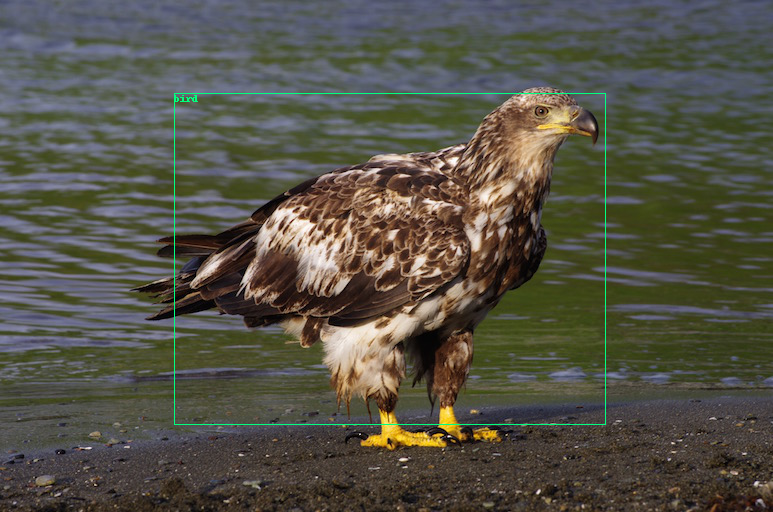

In [11]:
predict(model, 'data/eagle.jpg')

Prediction time: [16.04247 ms.]
bird      : 0.189038
bird      : 0.123983
bird      : 0.010301


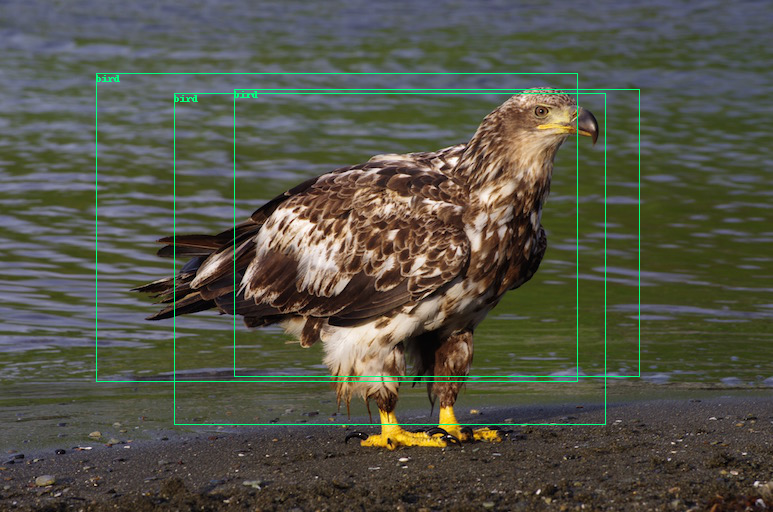

In [12]:
predict(model, 'data/eagle.jpg', nms_thresh=0.7)

Prediction time: [28.57518 ms.]
dog       : 0.657305
cat       : 0.559892
car       : 0.345170
person    : 0.119102
person    : 0.115331
motorbike : 0.093730
bicycle   : 0.061055
car       : 0.061044
person    : 0.049663
cow       : 0.045747
motorbike : 0.035542
motorbike : 0.031446
chair     : 0.021431
sheep     : 0.019085
person    : 0.018600
bicycle   : 0.018483
person    : 0.017321
person    : 0.016583
sofa      : 0.016316
tvmonitor : 0.016305
person    : 0.014391
horse     : 0.010666
pottedplant: 0.010636
sheep     : 0.007628
person    : 0.007462
bird      : 0.005607
bird      : 0.004304
sofa      : 0.004171
chair     : 0.003438
person    : 0.002964
sheep     : 0.002924
chair     : 0.002892
tvmonitor : 0.002550
person    : 0.002296
pottedplant: 0.002271
aeroplane : 0.002261
pottedplant: 0.002158
bird      : 0.002135
sofa      : 0.001888
motorbike : 0.001871
bird      : 0.001715
pottedplant: 0.001496
bird      : 0.001407
cow       : 0.001162


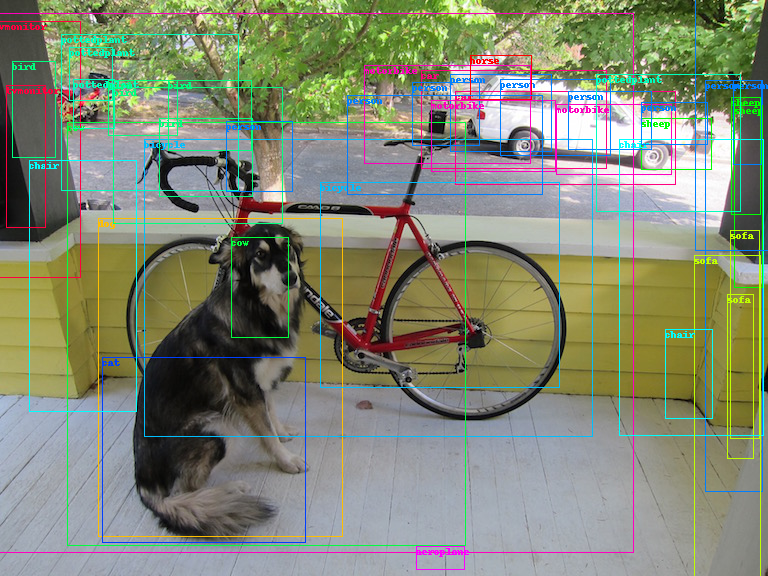

In [14]:
predict(model, 'data/dog.jpg', conf_thresh=0.01)

Prediction time: [18.52703 ms.]
sheep     : 0.202420
horse     : 0.148027
horse     : 0.134987


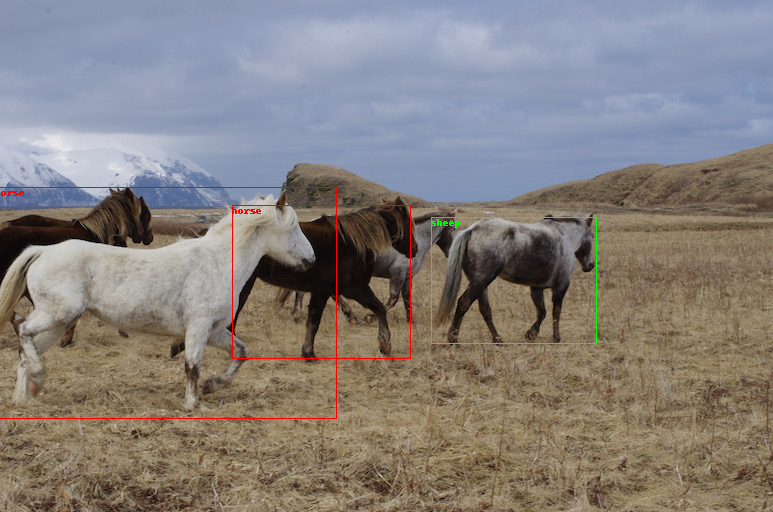

In [15]:
predict(model, 'data/horses.jpg')

Prediction time: [15.56635 ms.]
person    : 0.565022
cow       : 0.093072
sheep     : 0.065158
horse     : 0.044370


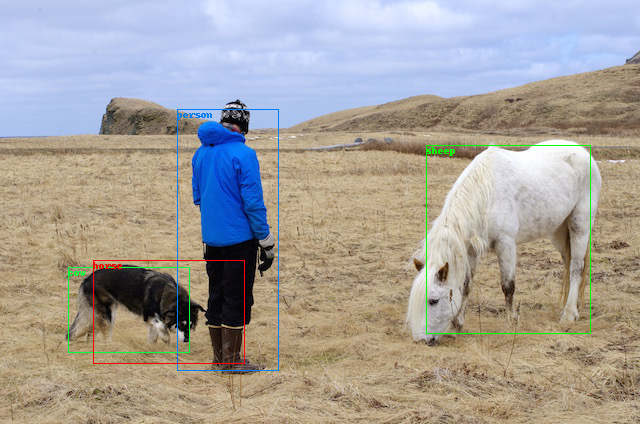

In [16]:
predict(model, 'data/person.jpg')

Prediction time: [15.57541 ms.]


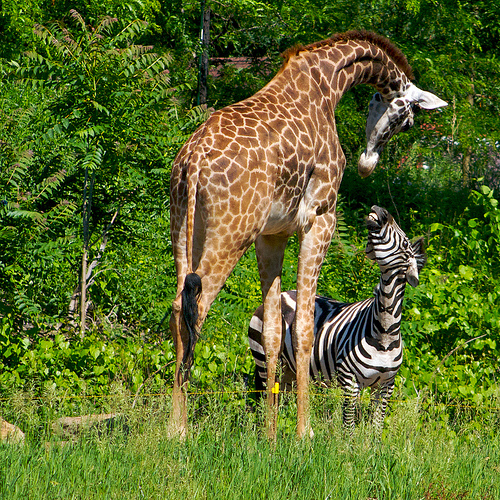

In [17]:
predict(model, 'data/giraffe.jpg')

## YOLO2

### Improvements

- Faster and more accurate (mAP 73.4 over PASCAL dataset).
- Can detect up to 9000 classes.

### Ideas

- Added **Batchnorm**
- Pre-train on imagenet at **multiple scales** (224x224) then (448x448), then only after they train for detection.
- Now they use **anchor boxes** like Faster-RCNN , the classification is done per-box shape, instead of per each grid-cell
- Instead of manually choose the box shape, they use **K-means** to get a box shape based on data
- Train the network at **multiple** scales, as the network is now Fully Convolutional (NO FC layer) this is easy to do.
- They train on both **Image-net and MS-COCO**
- They create a new mechanism to train on datasets that don't have detection data. By selecting on the multi-part loss function what to propagate.
- Use **WordTree** to combine data from various sources and our joint optimization technique to train simultaneously on ImageNet and COCO.


In [18]:
from yolo_v2 import YoloNet

In [19]:
def load_yolo2(num_classes, anchors, weights):
    yolo = YoloNet(num_classes, anchors)
    yolo.load_state_dict(torch.load(weights))
    return yolo.cuda() if use_gpu else yolo

<h6>Note: </h6> You need the weights (`yolo.pth`) to be able to run the codes.

In [20]:
weight_file = 'weights/yolo.pth'

# anchor and classes information
class_names = open('data/coco.names').read().split('\n')
num_classes = len(class_names)

anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

image_size = 608

In [21]:
model = load_yolo2(num_classes, anchors, weight_file)

Prediction time: [51.76973 ms.]
truck     : 0.796801
dog       : 0.550488
bicycle   : 0.169702
motorbike : 0.041152


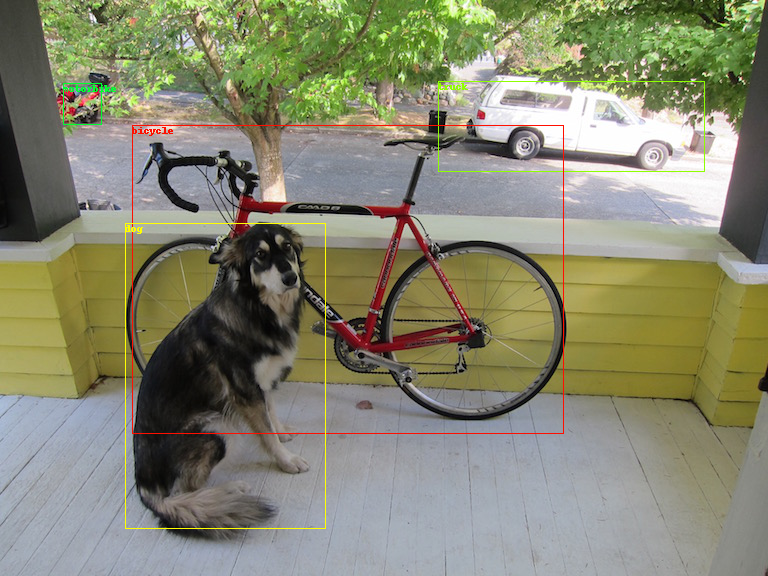

In [22]:
predict(model, 'data/dog.jpg', conf_thresh=0.3)

Prediction time: [48.59519 ms.]
bird      : 0.035750


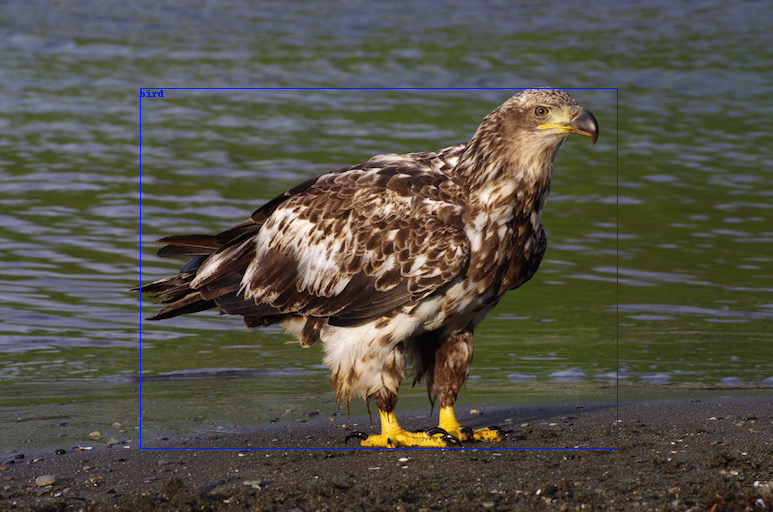

In [23]:
predict(model, 'data/eagle.jpg')

Prediction time: [38.10048 ms.]
dog       : 0.812998
person    : 0.764098
horse     : 0.223396


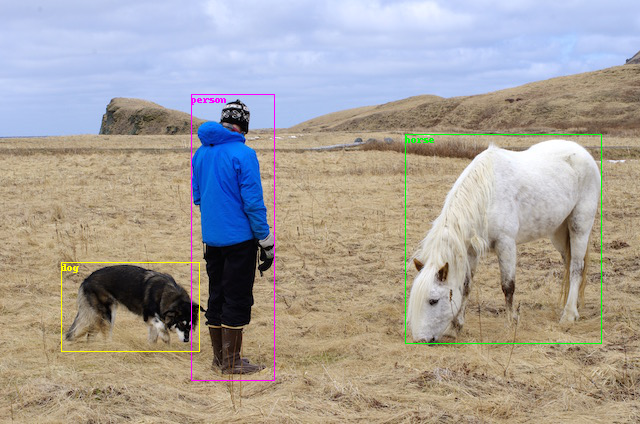

In [24]:
predict(model, 'data/person.jpg')

Prediction time: [70.55950 ms.]
horse     : 0.115737
horse     : 0.049542
zebra     : 0.028921
horse     : 0.005366


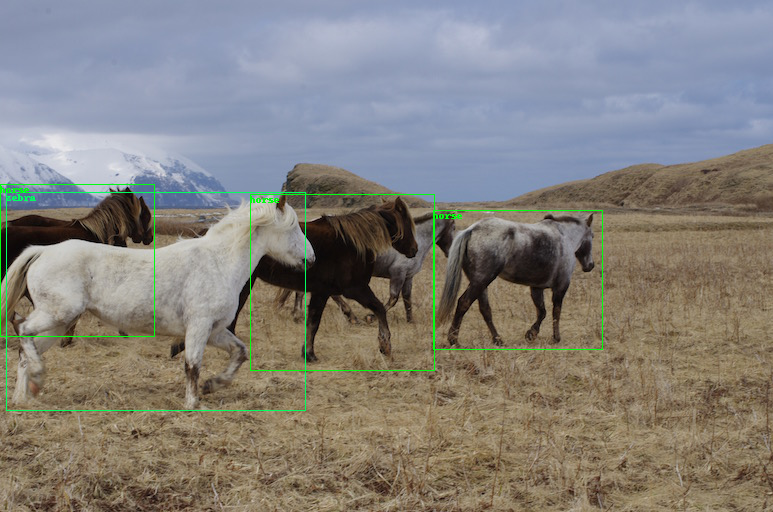

In [25]:
predict(model, 'data/horses.jpg', img_size=608)

Prediction time: [65.66358 ms.]
zebra     : 0.110691
giraffe   : 0.082759


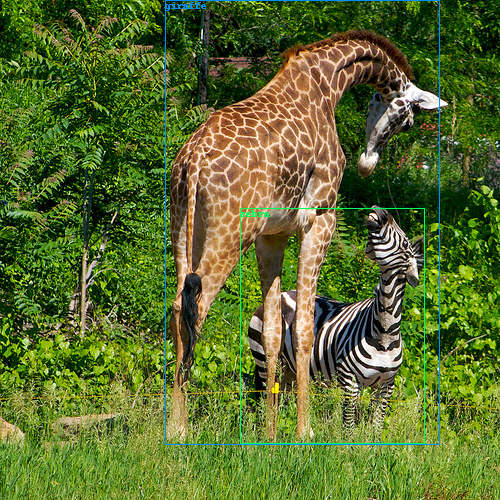

In [26]:
predict(model, 'data/giraffe.jpg', img_size=608)

## Yolo2 Architecture 

<img src='imgs/yolo-v2-arch.png' width='90%'/>

```python
def forward(self, x):
    x1, x2 = self.darknet(x)
    x1 = self.conv1(x1)
    x2 = self.conv2(x2)  # conv and reorg
    x = torch.cat([x2, x1], 1)
    x = self.conv3(x)
    return x
```

### Comparision to other Detectors

<img src='imgs/yolo-comparision.png' width='60%'/>

## References

- [YOLO web site](https://pjreddie.com/darknet/yolo/)